In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import json
from datetime import datetime
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from HSI_class import HSI
import zeroPadding
import augmentation as aug
import createSample as CS

start_time = time.time()

# Check if GPU is available
print("GPU Available:", torch.cuda.is_available())

# If available, print the GPU name
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

seeded_run = True
seed = 55

sample_per_class = 5
num_per_category_augment_1 = 10
num_per_category_augment_2 = 10
epochs = 200

batch_size =40
test_size = 0.5

random_indices = 0

GPU Available: True
GPU Name: NVIDIA GeForce RTX 4080 SUPER


In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Might slow down training, but ensures determinism

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

if seeded_run:
    set_seed(seed)
    print("seed has been set")

seed has been set


In [3]:
dataset_path = r"D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets"

datasets = []

i = 0
for filename in os.listdir(dataset_path):
    if i>9:
        break
    file_path = os.path.join(dataset_path, filename)
    if os.path.isfile(file_path):  # Check if it's a file
        print(f"Processing file: {file_path}")
        hsi = HSI(file_path)
        datasets.append(hsi)
    i += 1

Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM01.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM02.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM03.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM04.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM05.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM06.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM07.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM08.mat


In [4]:
def testWithDataset(n): 
    hsi_test = datasets[n]

    test_img = hsi_test.img
    test_gt = hsi_test.gt

    patch_size = 9
    half_patch = patch_size // 2

    height = test_img.shape[0]
    width = test_img.shape[1]

    matrix=zeroPadding.zeroPadding_3D(test_img,half_patch) #add 0 in every side of the data
    print(f"img shape: {test_img.shape}")
    print(f"img shape after padding {matrix.shape}")
    print(f"number of pixel {width * height}")

    print(f"ground truth shape: {test_gt.shape}")

    indices0 = np.argwhere(test_gt == 0)
    indices1 = np.argwhere(test_gt == 1)

    print(f"indices = 0 shape: {indices0.shape}")
    print(f"indices = 1 shape: {indices1.shape}")

    num_samples = 50

    random_indices0 = indices0[np.random.choice(len(indices0), num_samples, replace=False)]
    random_indices1 = indices1[np.random.choice(len(indices1), num_samples, replace=False)]

    test_indices = np.vstack((random_indices0, random_indices1))

    print(test_indices.shape)

    return test_indices, test_gt, matrix

In [5]:
hsi_ = datasets[0]
patch_size = 9

indices_0 = []
indices_1 = []

print(f"random: {random_indices}")
random_indices = 1
if random_indices:
    print("generating random sample")
    selected_patch_0, selected_patch_1, indices_0, indices_1 = CS.createSample(hsi_, patch_size, sample_per_class)
else:
    print("using generated indices")
    indices_0 = [(np.int64(188), np.int64(124)), (np.int64(523), np.int64(150)), (np.int64(1003), np.int64(474)), (np.int64(616), np.int64(508)), (np.int64(905), np.int64(552))]
    indices_1 = [(np.int64(106), np.int64(606)), (np.int64(297), np.int64(468)), (np.int64(926), np.int64(35)), (np.int64(536), np.int64(519)), (np.int64(508), np.int64(442))]

    selected_patch_0, selected_patch_1 = CS.getSample(hsi_, patch_size, sample_per_class, indices_0, indices_1)


i =0
half_patch = patch_size // 2


indices = indices_0 +  indices_1

# Concatenating along axis 0
x_train = np.concatenate((selected_patch_0, selected_patch_1), )

y_train = np.array([])

gt = hsi_.gt
for indice in indices:
    # print(gt[indice[0]][indice[1]])
    y_train = np.append(y_train, gt[indice[0]][indice[1]])

count = np.count_nonzero(y_train == 0)  # Count elements equal to 0
print(f'number of element equal 0 {count}')

count = np.count_nonzero(y_train == 1)  # Count elements equal to 1
print(f'number of element equal 1 {count}')



# Print shape to verify
print(f"x_train shape: {x_train.shape}")  # Expected output: (10, 9, 9, 224)
print(f"y_train shape: {y_train.shape}") 


random: 0
generating random sample
hsi shape
(1243, 684, 224)
creating 5 Randomly chosen 0 indices:
creating 5 Randomly chosen 1 indices:
indices 0 used: [(np.int64(144), np.int64(561)), (np.int64(319), np.int64(409)), (np.int64(244), np.int64(479)), (np.int64(1175), np.int64(174)), (np.int64(488), np.int64(196))]
indices 1 used: [(np.int64(1102), np.int64(103)), (np.int64(113), np.int64(43)), (np.int64(963), np.int64(39)), (np.int64(160), np.int64(195)), (np.int64(232), np.int64(222))]
number of element equal 0 5
number of element equal 1 5
x_train shape: (10, 9, 9, 224)
y_train shape: (10,)


In [6]:
i =1
half_patch = patch_size // 2
print(hsi_.img[indices_0[i][0]][indices_0[i][1]])
print(selected_patch_0[i][half_patch][half_patch])

print(hsi_.img[indices_1[i][0]][indices_1[i][1]])
print(selected_patch_1[i][half_patch][half_patch])
i =4
half_patch = patch_size // 2
print(hsi_.img[indices_0[i][0]][indices_0[i][1]])
print(selected_patch_0[i][half_patch][half_patch])

print(hsi_.img[indices_1[i][0]][indices_1[i][1]])
print(selected_patch_1[i][half_patch][half_patch])

[-245 -455  358  410  441  591  649  646  622  601  559  504  461  430
  400  382  349  326  304  281  246  227  200  177  148  141  127  119
  112  108   97   88   91   85   78   72   58   51   40   14   31   45
   51   23   37   46   40   38   37   24   22   26   43   40   38   34
   38   20    8    1    8   -3 -143  -49    9   19   31   40   40   46
   47   39   45   44   47   42   32   27   15  -16 -191 -193  -93  -85
  -20    9   25   18   27   18   38   31   43   39   34   47   36   26
   22   11   17   10    0  152  -18  -54    0    0    0    0    0    0
    0    0 -342 -304  -89  -50 -109  -46   -3   -2    5   10   10   17
   16   10    8   19   16    9   18   16   14   15   12   13   14   16
   19   20   19   10   17   -1    6    5    1   -9    3   47    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  -23  -42  -11    3   -8  -18  -47   -2    8   10    9   12    9   11
   14   14   10   18   14   21   17   20   18   18   11   17   16   15
   16 

In [7]:
n_category = 2
band_size = 224

data_augment1, label_augment1 = aug.Augment_data(x_train, y_train, n_category, patch_size, band_size, num_per_category_augment_1)

data_augment2, label_augment2 = aug.Augment_data2(x_train, y_train, n_category, patch_size, band_size, num_per_category_augment_2)

print(f"hasil augmentasi 1 shape: {data_augment1.shape}")
print(f"label augmentai 1 shape: {label_augment1.shape}")

print(f"hasil augmentasi 2 shape: {data_augment2.shape}")
print(f"label augmentasi 2 shape: {label_augment2.shape}")

print(label_augment1)
print(label_augment2)

data_augment = np.concatenate((data_augment1, data_augment2))
label_augment = np.concatenate((label_augment1, label_augment2))

print(f"hasil augmentasi gabungan untuk training: {data_augment.shape}")
print(f"label augmentasi gabungan: {label_augment.shape}")

# print(label_augment)

# Count occurrences of each unique element
counts = np.bincount(label_augment)

# Print results
for i, count in enumerate(counts):
    print(f"Element {i} occurs {count} times.")

hasil augmentasi 1 shape: (20, 9, 9, 224)
label augmentai 1 shape: (20,)
hasil augmentasi 2 shape: (20, 9, 9, 224)
label augmentasi 2 shape: (20,)
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
hasil augmentasi gabungan untuk training: (40, 9, 9, 224)
label augmentasi gabungan: (40,)
Element 0 occurs 20 times.
Element 1 occurs 20 times.


In [8]:
print(data_augment.shape)
print(label_augment.shape)

x_data = data_augment 
y_labels = label_augment

x_data = torch.tensor(x_data)
x_data = x_data.to(torch.float32)
x_data = x_data.permute(0, 3, 1, 2)
print(f"X_train shape: {x_data.shape}")


features_np = x_data.numpy() 
print(features_np.shape)

(40, 9, 9, 224)
(40,)
X_train shape: torch.Size([40, 224, 9, 9])
(40, 224, 9, 9)


In [9]:
X = features_np
y = y_labels
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=seed)

print(y_train)
print(y_val)

[1 1 1 1 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 1]
[0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1 1 1 0]


In [10]:
class HybridSN_Binary(nn.Module):
    def __init__(self, input_channels=1, spectral_bands=224, height=9, width=9):
        super(HybridSN_Binary, self).__init__()

        self.conv3d_1 = nn.Conv3d(input_channels, 8, kernel_size=(3, 3, 7), padding=(1, 1, 3))
        self.conv3d_2 = nn.Conv3d(8, 16, kernel_size=(3, 3, 5), padding=(1, 1, 2))
        self.conv3d_3 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3), padding=(1, 1, 1))

        self.conv2d = nn.Conv2d(32 * spectral_bands, 64, kernel_size=(3, 3), padding=1)

        self.flattened_size = 64 * height * width

        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)  # single output neuron for binary classification

    def forward(self, x):
        x = F.relu(self.conv3d_1(x))  # [B, 8, 224, 9, 9]
        x = F.relu(self.conv3d_2(x))  # [B, 16, 224, 9, 9]
        x = F.relu(self.conv3d_3(x))  # [B, 32, 224, 9, 9]

        # Merge spectral and channel dimensions: [B, 32 * 224, 9, 9]
        B, C, D, H, W = x.shape
        x = x.view(B, C * D, H, W)

        x = F.relu(self.conv2d(x))  # Conv2d now expects input with more channels

        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output logit

        return x.squeeze(1)  # Output shape: (B,)



In [11]:

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

print(X_train_tensor.shape)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor )
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

if seeded_run:
    g = torch.Generator()
    g.manual_seed(seed)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,  # set to True if needed
        num_workers=0,
        pin_memory=True,
        drop_last=False,
        generator=g
    )
    print("generate data loader using seed")
else:
    train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

input_channels = X_train_tensor.shape[1]
print(input_channels)

torch.Size([20, 1, 224, 9, 9])
generate data loader using seed
1


In [12]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridSN_Binary(input_channels=1, spectral_bands=224, height=9, width=9)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(100):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze(1)
        # print(labels.shape)
        # print(labels)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/100, Loss: {loss.item():.4f}")


Epoch 1/100, Loss: 32.6667
Epoch 2/100, Loss: 94.2324
Epoch 3/100, Loss: 78.5769
Epoch 4/100, Loss: 53.5965
Epoch 5/100, Loss: 40.4585
Epoch 6/100, Loss: 28.7850
Epoch 7/100, Loss: 30.9246
Epoch 8/100, Loss: 29.7756
Epoch 9/100, Loss: 29.4321
Epoch 10/100, Loss: 29.1615
Epoch 11/100, Loss: 28.5590
Epoch 12/100, Loss: 28.0043
Epoch 13/100, Loss: 27.9825
Epoch 14/100, Loss: 27.5066
Epoch 15/100, Loss: 27.3005
Epoch 16/100, Loss: 27.0627
Epoch 17/100, Loss: 27.0629
Epoch 18/100, Loss: 26.8038
Epoch 19/100, Loss: 26.8284
Epoch 20/100, Loss: 26.7076
Epoch 21/100, Loss: 26.6995
Epoch 22/100, Loss: 26.5995
Epoch 23/100, Loss: 26.6572
Epoch 24/100, Loss: 26.5576
Epoch 25/100, Loss: 26.4905
Epoch 26/100, Loss: 26.5803
Epoch 27/100, Loss: 26.5128
Epoch 28/100, Loss: 26.4512
Epoch 29/100, Loss: 26.4873
Epoch 30/100, Loss: 26.4530
Epoch 31/100, Loss: 26.4174
Epoch 32/100, Loss: 26.4502
Epoch 33/100, Loss: 26.4593
Epoch 34/100, Loss: 26.4464
Epoch 35/100, Loss: 26.4178
Epoch 36/100, Loss: 26.4093
E

In [13]:
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_val_tensor   = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

In [14]:
model.eval()
with torch.no_grad():
    val_outputs = model(X_val_tensor.to(device)).cpu().squeeze()
    val_probs = torch.sigmoid(val_outputs)
    val_preds = (val_probs >= 0.5).int().numpy()

# Accuracy
acc = accuracy_score(y_val, val_preds)
print(f"Validation Accuracy: {acc:.4f}")

# Print predictions and probabilities
for i, (pred, prob) in enumerate(zip(val_preds, val_probs)):
    print(f"Sample {i}: Predicted = {pred}, Prob(class 1) = {prob:.4f}")


Validation Accuracy: 0.5500
Sample 0: Predicted = 0, Prob(class 1) = 0.0001
Sample 1: Predicted = 0, Prob(class 1) = 0.0000
Sample 2: Predicted = 0, Prob(class 1) = 0.0000
Sample 3: Predicted = 0, Prob(class 1) = 0.4802
Sample 4: Predicted = 0, Prob(class 1) = 0.0001
Sample 5: Predicted = 0, Prob(class 1) = 0.0001
Sample 6: Predicted = 0, Prob(class 1) = 0.2485
Sample 7: Predicted = 0, Prob(class 1) = 0.0000
Sample 8: Predicted = 0, Prob(class 1) = 0.0000
Sample 9: Predicted = 0, Prob(class 1) = 0.0001
Sample 10: Predicted = 0, Prob(class 1) = 0.0005
Sample 11: Predicted = 0, Prob(class 1) = 0.4799
Sample 12: Predicted = 0, Prob(class 1) = 0.4905
Sample 13: Predicted = 0, Prob(class 1) = 0.0000
Sample 14: Predicted = 0, Prob(class 1) = 0.4842
Sample 15: Predicted = 0, Prob(class 1) = 0.4898
Sample 16: Predicted = 0, Prob(class 1) = 0.4840
Sample 17: Predicted = 0, Prob(class 1) = 0.4837
Sample 18: Predicted = 0, Prob(class 1) = 0.3658
Sample 19: Predicted = 0, Prob(class 1) = 0.0000


In [15]:
def predict_batch_whole(model, batch_input, device):
    batch_input = batch_input.unsqueeze(1).to(device)
    # print(batch_input.shape)
    with torch.no_grad():  # Disable gradient computation
        val_outputs = model(batch_input).cpu()  # shape (B,)
        val_probs = torch.sigmoid(val_outputs)              # convert logits to probabilities
        val_preds = (val_probs >= 0.5).int().numpy()

    return val_preds, val_probs

In [16]:
def testWithWholeDataset(n): 
    hsi_test = datasets[n]

    test_img = hsi_test.img
    gt= hsi_test.gt

    patch_size = 9
    half_patch = patch_size // 2

    height = test_img.shape[0]
    width = test_img.shape[1]

    matrix=zeroPadding.zeroPadding_3D(test_img,half_patch) #add 0 in every side of the data
    print(f"img shape: {test_img.shape}")
    print(f"img shape after padding {matrix.shape}")
    print(f"number of pixel {width * height}")

    print(f"ground truth shape: {gt.shape}")

    indices0 = np.argwhere(gt == 0)
    indices1 = np.argwhere(gt == 1)

    print(f"indices = 0 shape: {indices0.shape}")
    print(f"indices = 1 shape: {indices1.shape}")

    return matrix, gt, indices0.shape, indices1.shape

In [17]:
class PatchDataset(Dataset):
    def __init__(self, matrix, gt, half_patch, expected_shape):
        self.matrix = matrix
        self.gt = gt
        self.half_patch = half_patch
        self.expected_shape = expected_shape
        self.size_x, self.size_y = matrix.shape[0], matrix.shape[1]
        self.valid_coords = [
            (x, y)
            for x in range(half_patch, self.size_x - half_patch)
            for y in range(half_patch, self.size_y - half_patch)
        ]

    def __len__(self):
        return len(self.valid_coords)

    def __getitem__(self, idx):
        x, y = self.valid_coords[idx]
        true_label = self.gt[x - self.half_patch, y - self.half_patch]

        selected_rows = self.matrix[x- self.half_patch:x + 2 * self.half_patch + 1 - self.half_patch, :]
        testing_patch = selected_rows[:, y - self.half_patch:y + 2 * self.half_patch + 1 - self.half_patch]

        # Verify patch size
        if testing_patch.shape != self.expected_shape:
            raise ValueError(f"Patch at ({x},{y}) has wrong shape {testing_patch.shape}")

        patch_tensor = torch.tensor(testing_patch, dtype=torch.float32)
        patch_tensor = patch_tensor.permute(2, 0, 1)  # (C, H, W)

        return patch_tensor, true_label, x, y  # Also return (x, y) for positioning later

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

scores = []
groundtruth = []
prediction = []
y_probs = []


timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
os.makedirs(f"predictions/{timestamp}", exist_ok=True)
for dataset in range(len(datasets)):

    score = []
    patch_size = 9
    half_patch = patch_size // 2

    data_sampler = None
    batch_size = 64

    correct0 = 0
    correct1 = 0
    matrix = []
    gt = []
    expected_patch_shape = []
    dataset_patches = []
    data_loader = []
    patch_tensor = []
    true_label = [] 
    x = []
    y = []
    pred_matrix = []

    matrix, gt, indices_0_shape, indices_1_shape = testWithWholeDataset(dataset)
    print(indices_0_shape[0])
    print(indices_1_shape[0])

    expected_patch_shape = (2 * half_patch + 1, 2 * half_patch + 1, matrix.shape[2])
    dataset_patches = PatchDataset(matrix, gt, half_patch, expected_patch_shape)

    if seeded_run:
        g = torch.Generator()
        g.manual_seed(seed)

        data_loader = DataLoader(
            dataset_patches,
            batch_size=batch_size,
            shuffle=False,  # set to True if needed
            num_workers=0,
            pin_memory=True,
            drop_last=False,
            generator=g
        )
        print("generate data loader using seed")
    else:
        data_loader = DataLoader(dataset_patches, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)




    patch_tensor, true_label, x, y = next(iter(data_loader))

    print(patch_tensor.size())
    print(true_label.size())
    print(f"data loader size: {len(data_loader)}")

    pred_matrix = np.full(gt.shape, -1, dtype=np.int32)
    correct = 0

    for input_batch, label_batch, x_batch, y_batch in tqdm(data_loader, desc="Predicting"):


        preds, confs = predict_batch_whole(model, input_batch, device)

        prediction.append(preds)
        y_probs.append(confs)
        
        label_batch = label_batch.numpy()
        x_batch = x_batch.numpy()
        y_batch = y_batch.numpy()

        for pred, label, x, y in zip(preds, label_batch, x_batch, y_batch):
            groundtruth.append(label)
            pred_matrix[x - half_patch, y - half_patch] = pred
            if pred == label:
                if label == 0:
                    correct0 += 1
                elif label == 1:
                    correct1 += 1
                
    correct = correct0+correct1
    print(f"correct0 = {correct0}")
    print(f"correct1 = {correct1}")
    total = gt.shape[0] * gt.shape[1]
    print(f"Score: {correct}/{total}")

    score = {
        'dataset': dataset,
        'class0_size': indices_0_shape[0],
        'class1_size': indices_1_shape[0],
        'correct_0': correct0,
        'correct_1': correct1,
        'correct_total': correct,
        'total': total
    }
    print(score)
    scores.append(score)
    # Save prediction matrix
    # timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    np.save(f"predictions/{timestamp}/results {dataset} HybridSN.npy", pred_matrix)

img shape: (1243, 684, 224)
img shape after padding (1251, 692, 224)
number of pixel 850212
ground truth shape: (1243, 684)
indices = 0 shape: (820876, 2)
indices = 1 shape: (29336, 2)
820876
29336
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 13285


Predicting: 100%|██████████| 13285/13285 [02:43<00:00, 81.30it/s]


correct0 = 816030
correct1 = 11101
Score: 827131/850212
{'dataset': 0, 'class0_size': 820876, 'class1_size': 29336, 'correct_0': 816030, 'correct_1': 11101, 'correct_total': 827131, 'total': 850212}
img shape: (1786, 699, 224)
img shape after padding (1794, 707, 224)
number of pixel 1248414
ground truth shape: (1786, 699)
indices = 0 shape: (1236269, 2)
indices = 1 shape: (12145, 2)
1236269
12145
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 19507


Predicting: 100%|██████████| 19507/19507 [04:11<00:00, 77.55it/s]


correct0 = 1003734
correct1 = 10462
Score: 1014196/1248414
{'dataset': 1, 'class0_size': 1236269, 'class1_size': 12145, 'correct_0': 1003734, 'correct_1': 10462, 'correct_total': 1014196, 'total': 1248414}
img shape: (1386, 690, 224)
img shape after padding (1394, 698, 224)
number of pixel 956340
ground truth shape: (1386, 690)
indices = 0 shape: (916980, 2)
indices = 1 shape: (39360, 2)
916980
39360
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 14943


Predicting: 100%|██████████| 14943/14943 [03:11<00:00, 78.23it/s]


correct0 = 850174
correct1 = 35448
Score: 885622/956340
{'dataset': 2, 'class0_size': 916980, 'class1_size': 39360, 'correct_0': 850174, 'correct_1': 35448, 'correct_total': 885622, 'total': 956340}
img shape: (1466, 676, 224)
img shape after padding (1474, 684, 224)
number of pixel 991016
ground truth shape: (1466, 676)
indices = 0 shape: (959167, 2)
indices = 1 shape: (31849, 2)
959167
31849
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 15485


Predicting: 100%|██████████| 15485/15485 [03:18<00:00, 77.82it/s]


correct0 = 944465
correct1 = 24445
Score: 968910/991016
{'dataset': 3, 'class0_size': 959167, 'class1_size': 31849, 'correct_0': 944465, 'correct_1': 24445, 'correct_total': 968910, 'total': 991016}
img shape: (2085, 682, 224)
img shape after padding (2093, 690, 224)
number of pixel 1421970
ground truth shape: (2085, 682)
indices = 0 shape: (1363408, 2)
indices = 1 shape: (58562, 2)
1363408
58562
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 22219


Predicting: 100%|██████████| 22219/22219 [04:35<00:00, 80.62it/s]


correct0 = 1321033
correct1 = 35516
Score: 1356549/1421970
{'dataset': 4, 'class0_size': 1363408, 'class1_size': 58562, 'correct_0': 1321033, 'correct_1': 35516, 'correct_total': 1356549, 'total': 1421970}
img shape: (2088, 691, 224)
img shape after padding (2096, 699, 224)
number of pixel 1442808
ground truth shape: (2088, 691)
indices = 0 shape: (1389552, 2)
indices = 1 shape: (53256, 2)
1389552
53256
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 22544


Predicting: 100%|██████████| 22544/22544 [04:16<00:00, 87.92it/s]


correct0 = 1368328
correct1 = 13771
Score: 1382099/1442808
{'dataset': 5, 'class0_size': 1389552, 'class1_size': 53256, 'correct_0': 1368328, 'correct_1': 13771, 'correct_total': 1382099, 'total': 1442808}
img shape: (1965, 492, 224)
img shape after padding (1973, 500, 224)
number of pixel 966780
ground truth shape: (1965, 492)
indices = 0 shape: (873365, 2)
indices = 1 shape: (93415, 2)
873365
93415
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 15106


Predicting: 100%|██████████| 15106/15106 [02:51<00:00, 88.01it/s]


correct0 = 870870
correct1 = 32107
Score: 902977/966780
{'dataset': 6, 'class0_size': 873365, 'class1_size': 93415, 'correct_0': 870870, 'correct_1': 32107, 'correct_total': 902977, 'total': 966780}
img shape: (1532, 567, 224)
img shape after padding (1540, 575, 224)
number of pixel 868644
ground truth shape: (1532, 567)
indices = 0 shape: (824964, 2)
indices = 1 shape: (43680, 2)
824964
43680
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 13573


Predicting: 100%|██████████| 13573/13573 [02:34<00:00, 87.79it/s]


correct0 = 824616
correct1 = 10002
Score: 834618/868644
{'dataset': 7, 'class0_size': 824964, 'class1_size': 43680, 'correct_0': 824616, 'correct_1': 10002, 'correct_total': 834618, 'total': 868644}
img shape: (1569, 517, 224)
img shape after padding (1577, 525, 224)
number of pixel 811173
ground truth shape: (1569, 517)
indices = 0 shape: (742935, 2)
indices = 1 shape: (68238, 2)
742935
68238
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 12675


Predicting: 100%|██████████| 12675/12675 [02:18<00:00, 91.23it/s]


correct0 = 740701
correct1 = 3250
Score: 743951/811173
{'dataset': 8, 'class0_size': 742935, 'class1_size': 68238, 'correct_0': 740701, 'correct_1': 3250, 'correct_total': 743951, 'total': 811173}
img shape: (1084, 680, 224)
img shape after padding (1092, 688, 224)
number of pixel 737120
ground truth shape: (1084, 680)
indices = 0 shape: (691437, 2)
indices = 1 shape: (45683, 2)
691437
45683
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 11518


Predicting: 100%|██████████| 11518/11518 [02:03<00:00, 93.23it/s]

correct0 = 690841
correct1 = 618
Score: 691459/737120
{'dataset': 9, 'class0_size': 691437, 'class1_size': 45683, 'correct_0': 690841, 'correct_1': 618, 'correct_total': 691459, 'total': 737120}


In [19]:
all_correct = 0
all_total = 0
all_correct0 = 0
all_correct1 = 0
class0_total = 0
class1_total = 0

for score in scores:
    dataset = score['dataset']
    correct0 = score['correct_0']
    correct1 = score['correct_1']
    class0_size = score['class0_size']
    class1_size = score['class1_size']
    correct = score['correct_total']
    total = score['total']
    print(f"dataset: {dataset}\t", f'{correct0}/{class0_size}\t', f'{correct1}/{class1_size}\t', f'{correct}/{total}\t')

    all_correct += correct
    all_total += total
    all_correct0 += correct0
    all_correct1 += correct1
    class0_total += class0_size
    class1_total += class1_size



print(f"total: \t\t {all_correct0}/{class0_total/2} \t {all_correct1}/{class1_total/2} \t {all_correct}/{all_total}")

print(f"acc: {all_correct/all_total}")



dataset: 0	 816030/820876	 11101/29336	 827131/850212	
dataset: 1	 1003734/1236269	 10462/12145	 1014196/1248414	
dataset: 2	 850174/916980	 35448/39360	 885622/956340	
dataset: 3	 944465/959167	 24445/31849	 968910/991016	
dataset: 4	 1321033/1363408	 35516/58562	 1356549/1421970	
dataset: 5	 1368328/1389552	 13771/53256	 1382099/1442808	
dataset: 6	 870870/873365	 32107/93415	 902977/966780	
dataset: 7	 824616/824964	 10002/43680	 834618/868644	
dataset: 8	 740701/742935	 3250/68238	 743951/811173	
dataset: 9	 690841/691437	 618/45683	 691459/737120	
total: 		 9430792/4909476.5 	 176720/237762.0 	 9607512/10294477
acc: 0.933268586641167


In [20]:

all_total_score = {
    'dataset': 'Total Dataset',
    'correct_0': all_correct0,
    'correct_1': all_correct1,
    'class0_total': class0_total,
    'class1_total': class1_total,
    'correct_total': all_correct,
    'total': all_total
}

scores.append(all_total_score)

In [21]:
groundtruths = groundtruth
groundtruth_in = []

for x in groundtruths:
    groundtruth_in.append(x)

predictions = prediction
prediction_in = []

for x in predictions:
    for y in x:
        prediction_in.append(y)


y_prob_in = []

for x in y_probs:
    for y in x:
        y_prob_in.append(y)

print(len(groundtruth_in))
print(len(prediction_in))
print(len(y_prob_in))

10294477
10294477
10294477


In [22]:
y_test = groundtruth_in
y_pred = prediction_in
correct = 0
total = 0

for x, y in zip(y_test, y_pred):
    total += 1
    if x == y:
        correct += 1

print(f'{correct}/{total}')

9607512/10294477


In [23]:
y_test_np = np.array([label.item() for label in y_test])
# Ensure labels are binary (0 and 1)
print("Unique values in y_test:", pd.Series(y_test_np).unique())

# Check if y_pred is probability (float) or hard prediction (int)
print("Sample y_pred values:", y_pred[:5])

Unique values in y_test: [0 1]
Sample y_pred values: [np.int32(0), np.int32(0), np.int32(0), np.int32(0), np.int32(0)]


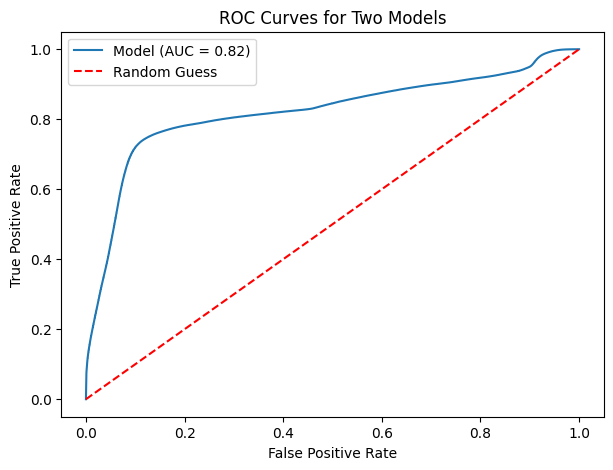

In [24]:
test_df = pd.DataFrame(
    {'True': y_test_np, 'Model': y_prob_in})

plt.figure(figsize=(7, 5))


fpr, tpr, _ = roc_curve(test_df['True'], test_df['Model'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Two Models')
plt.legend()
plt.show()

In [25]:


y_true = np.array([int(label) for label in y_test_np])  # true labels
y_pred = prediction_in                         # predicted class labels (e.g., from predict_batch)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred, average='macro')  # Use 'binary' if binary task
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Overall Accuracy (OA)
oa = accuracy_score(y_true, y_pred)

# Average Accuracy (AA) — mean of per-class accuracies
cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
aa = per_class_acc.mean()

# Print all metrics
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"OA:        {oa:.4f}")
print(f"AA:        {aa:.4f}")

Precision: 0.6411
Recall:    0.6661
F1 Score:  0.6523
OA:        0.9333
AA:        0.6661


In [26]:
performance = {
    'AUC': float(roc_auc),
    'precision': float(precision),
    'recall': float(recall),
    'F1 Score': float(f1),
    'OA': float(oa),
    'AA': float(aa),
}
result_json = {
    'prediction' : scores,
    'performance' : performance,
}

In [27]:
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
print(result_json)

with open(f"performance/HybridSN {timestamp}_results.json", "w") as f:
    json.dump(result_json, f, indent=2)

print("JSON saved to results.json")

{'prediction': [{'dataset': 0, 'class0_size': 820876, 'class1_size': 29336, 'correct_0': 816030, 'correct_1': 11101, 'correct_total': 827131, 'total': 850212}, {'dataset': 1, 'class0_size': 1236269, 'class1_size': 12145, 'correct_0': 1003734, 'correct_1': 10462, 'correct_total': 1014196, 'total': 1248414}, {'dataset': 2, 'class0_size': 916980, 'class1_size': 39360, 'correct_0': 850174, 'correct_1': 35448, 'correct_total': 885622, 'total': 956340}, {'dataset': 3, 'class0_size': 959167, 'class1_size': 31849, 'correct_0': 944465, 'correct_1': 24445, 'correct_total': 968910, 'total': 991016}, {'dataset': 4, 'class0_size': 1363408, 'class1_size': 58562, 'correct_0': 1321033, 'correct_1': 35516, 'correct_total': 1356549, 'total': 1421970}, {'dataset': 5, 'class0_size': 1389552, 'class1_size': 53256, 'correct_0': 1368328, 'correct_1': 13771, 'correct_total': 1382099, 'total': 1442808}, {'dataset': 6, 'class0_size': 873365, 'class1_size': 93415, 'correct_0': 870870, 'correct_1': 32107, 'correc

In [28]:
end_time = time.time()
print(f"Run time: {end_time - start_time:.4f} seconds")

print(timestamp)
print(f"seet used: {seed}")

Run time: 2495.5922 seconds
20250610_190400
seet used: 55
